In [81]:
import numpy as n
import torch.nn as nn
import matplotlib.pyplot as plt

c = 299792458

In [82]:
# Load raw data eventually obtained from concatenation
raw_data = np.load('/Users/jordy/Data/SHARAD/SAR/raw_data.npy')[:,:]
print('(Samples,Rangelines)',raw_data.shape)

(Samples,Rangelines) (3600, 78780)


In [83]:
# Decompression
presum = 4
bps = 8
raw_data = raw_data*2**(np.round(np.log2(presum))-bps+8)/presum
raw_data = raw_data-raw_data.mean()

In [84]:
samples, rangelines = raw_data.shape
sf = 80e6/3 # 80/3 MHz sampling frequency

In [85]:
# Topographic Shift. Topography has been obtained from ancillary files
topo = np.load('/Users/jordy/Data/SHARAD/SAR/topo.npy') * 1000 # in meters
topo = topo - topo.min()
print('Mean topography diff [km]', topo.mean())

# Sampling freq is 80/3 MHz -> dt = 3/80e6 s
# space = v * t = 3e8 * 3/80e6 s
dz = c/np.sqrt(3.15) * (1/sf) # Space within ice travelled by EM pulse in 1/SF seconds
print('dz [m]:', dz)

pixel_topo = topo/dz # Topographic shift in pixels
print('Mean pixel shift:',pixel_topo.mean())

# Shifting each row by topo shift in pixels
for i in range(raw_data.shape[1]):
    raw_data[:,i] = np.roll(raw_data[:,i], shift = -int(np.round(pixel_topo[i])))


Mean topography diff [km] 979.6589146594948
dz [m]: 6.334271785355503
Mean pixel shift: 154.66006951650127


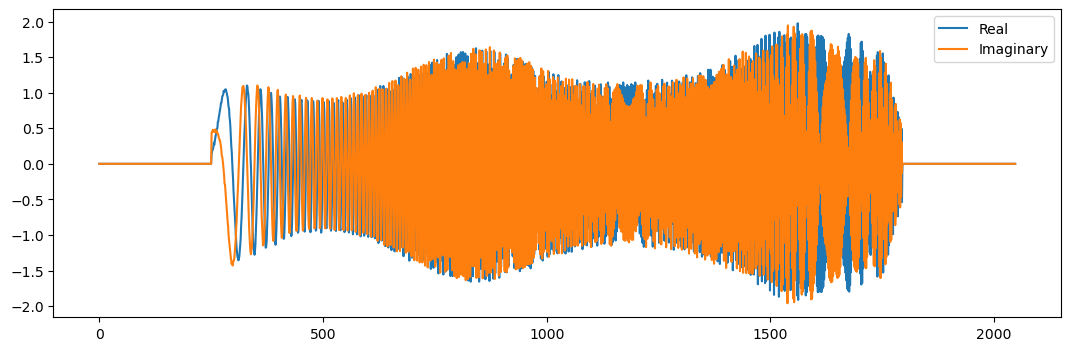

In [86]:
# Chirp
# Loading chirp as per SHARAD docs. One shoudl select the best chirp according to TX and RX temperatures.
chirpf = '/Users/jordy/Data/SHARAD/SAR/reference_chirp_p60tx_p20rx.dat'
POINTS = 2048
C = np.zeros((2,POINTS)) # first row is real, second row is imaginary
with open(chirpf, 'rb') as fid:
    C[0,:] = np.fromfile(fid, dtype='<f4', count=POINTS, offset= 0)
with open(chirpf, 'rb') as fid:
    C[1,:] = np.fromfile(fid, dtype='<f4', count=POINTS, offset= POINTS*4) #4 bytes per item

plt.figure(1, figsize = (13,4))
plt.plot(C[0,:])
plt.plot(C[1,:])
plt.legend(['Real','Imaginary'])

chirp = C[0,:] + 1j*C[1,:] # This is the spectrum of the chirp

In [87]:
# Pad raw data to nearest power of 2
to_pad = np.zeros((248, rangelines))
raw_data = np.concatenate([to_pad, raw_data, to_pad], axis = 0)
print('Padded raw data dimension:', raw_data.shape)

Padded raw data dimension: (4096, 78780)


In [88]:
# Time interval of the pulse sampled at SF
T = 1/sf*raw_data.shape[0]
t_signal = np.linspace(0,T-1/sf, raw_data.shape[0])
print(t_signal.shape)

(4096,)


In [ ]:
raw_data_complex = raw_data * np.exp(2*np.pi*(80/3 - 20)*1j*t_signal)[:,np.newaxis] # Complex demodulation

In [90]:
torch_chirp = torch.tensor(chirp, dtype=torch.complex64)
torch_raw_data = torch.tensor(raw_data_complex, dtype=torch.complex64)
print('Torch chirp shape:', torch_chirp.shape)
print('Torch raw data shape:', torch_raw_data.shape)

class RangeCompressionWithHann(nn.Module):
    def __init__(self, chirp, fft_crop_start: int, fft_crop_end: int):
        """
        chirp: complex-valued 1D numpy array (matched filter)
        fft_crop_start, fft_crop_end: cropping indices for FFT frequencies
        """
        super().__init__()
        self.fft_crop_start = fft_crop_start
        self.fft_crop_end = fft_crop_end
        crop_len = fft_crop_end - fft_crop_start

        # Process chirp: conjugate + fftshift
        chirp_conj = np.conj(chirp)
        chirp_shifted = np.fft.fftshift(chirp_conj)
        chirp_tensor = torch.tensor(chirp_shifted, dtype=torch.complex64)
        self.register_buffer("chirp_conj_shifted", chirp_tensor)

        # Hann window, fftshifted
        hann_np = np.hanning(crop_len)
        hann_shifted = np.fft.fftshift(hann_np)
        hann_tensor = torch.tensor(hann_shifted, dtype=torch.float32)
        self.register_buffer("hann_window_shifted", hann_tensor)

    def forward(self, raw_data: torch.Tensor):
        """
        raw_data: shape (fast_time, slow_time), dtype=torch.complex64
        Returns: range compressed data, shape (crop_len, slow_time)
        """
        # 1. FFT along fast-time (dim 0)
        signal_fft = torch.fft.fft(raw_data, dim=0)

        # 2. Crop central frequencies
        signal_fft = signal_fft[self.fft_crop_start:self.fft_crop_end, :]

        # 3. Matched filtering in frequency domain
        compressed_fft = self.chirp_conj_shifted[:, None] * signal_fft

        # 4. Hann windowing (broadcast over slow_time axis)
        windowed_fft = compressed_fft * self.hann_window_shifted[:, None]

        # 5. iFFT to get range-compressed signal
        range_compressed = torch.fft.ifft(windowed_fft, dim=0)

        return range_compressed  # Shape: (crop_len, slow_time)

Torch chirp shape: torch.Size([2048])
Torch raw data shape: torch.Size([4096, 78780])


In [91]:
model = RangeCompressionWithHann(torch_chirp, 1024, 3072)
out = model(torch_raw_data)

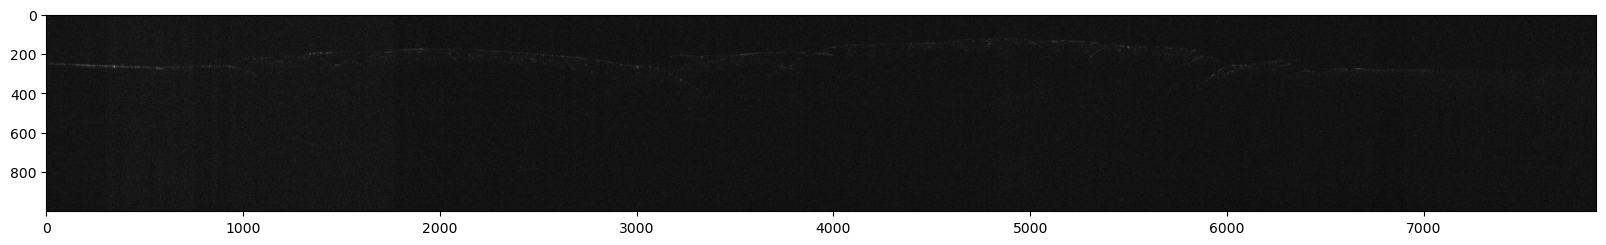

In [94]:
plt.figure(figsize = (20,4))
plt.imshow(torch.abs(out)[:1000, ::10], cmap = 'gray')

In [100]:
N, M = out.shape
x = 20
reshaped_out = out.view(N, M // x, x)
summed_out = reshaped_out.sum(dim=2)

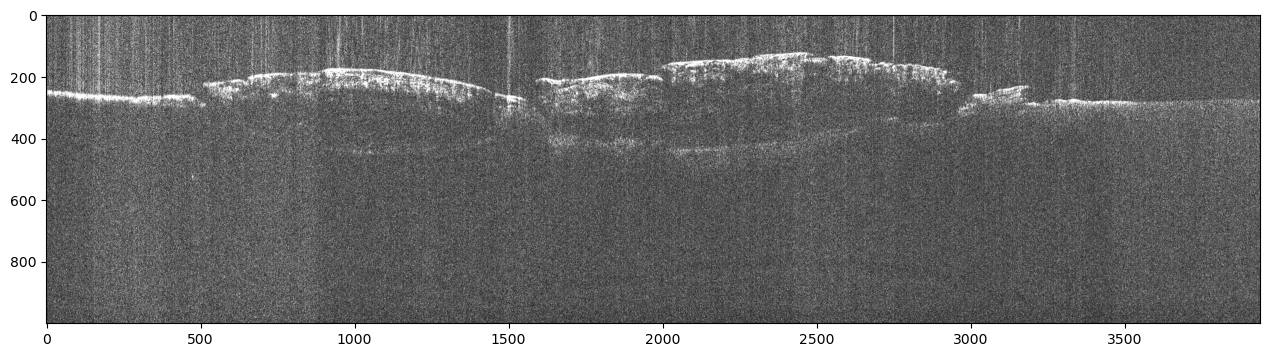

In [133]:
plt.figure(figsize = (20,4))
plt.imshow(torch.abs(summed_out)[:1000, :], cmap='grey', vmax = 200)

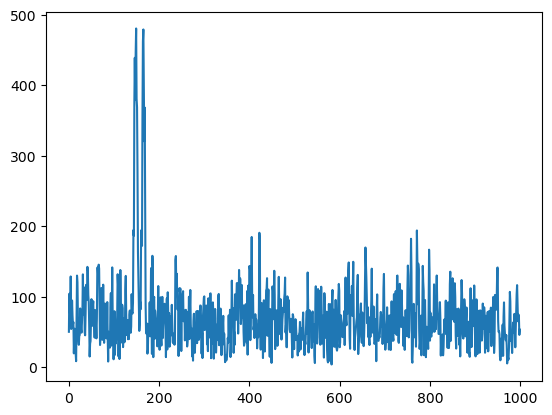

In [114]:
plt.plot((torch.abs(summed_out[:1000,2250])))